# Geospatial Data in Python

## Vector Data

We are going to use [geopandas](https://geopandas.org/) to work with some vector data layers.  Geopandas is built on top of pandas, the main addition is its ability to handle **Geometries**.  For this, it relies on another package called [shapely](https://shapely.readthedocs.io/en/stable/manual.html)


Text(0.5, 1.0, 'Verticies')

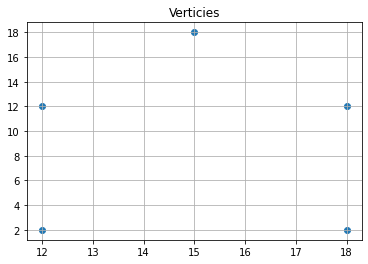

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd


%matplotlib inline

Y = np.array([2,12,18,12,2])
X = np.array([12,12,15,18,18])

fig,ax=plt.subplots()
ax.scatter(X,Y)
ax.grid()
ax.set_title('Verticies')

In [ ]:
from shapely.geometry import Polygon, LineString, Point


## Shapely Objects

### Point(s)

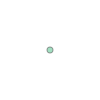

In [20]:
from shapely.geometry import Point

point = Point([X[0],Y[0]])

point

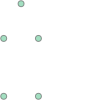

In [23]:
from shapely.geometry import MultiPoint

mulit_point = MultiPoint([x for x in zip(X, Y)])

mulit_point

### Polygon(s)

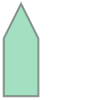

In [51]:
from shapely.geometry import Polygon

poly = Polygon([coord for coord in zip(X, Y)])

poly

[<shapely.geometry.polygon.Polygon object at 0x00000266E0E063D0>, <shapely.geometry.polygon.Polygon object at 0x00000266E0E06280>, <shapely.geometry.polygon.Polygon object at 0x00000266E0E06460>, <shapely.geometry.polygon.Polygon object at 0x00000266E0D9A790>]


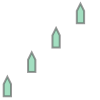

In [50]:
from shapely.geometry import MultiPolygon

Mpol = []
for i in range(0,61,20):
    Mpol.append(Polygon([coord for coord in zip(X+i, Y+i)]))

print(Mpol)
Mpoly = MultiPolygon(Mpol)

Mpoly

### Line(s)

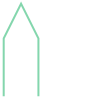

In [43]:
from shapely.geometry import LineString

line = LineString([x for x in zip(X, Y)])

line

[<shapely.geometry.linestring.LineString object at 0x00000266E0D9AB20>, <shapely.geometry.linestring.LineString object at 0x00000266E0D9AE20>, <shapely.geometry.linestring.LineString object at 0x00000266E0D9AD60>, <shapely.geometry.linestring.LineString object at 0x00000266E0D9A640>]


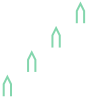

In [49]:
from shapely.geometry import MultiLineString

Mlin = []
for i in range(0,61,20):
    Mlin.append(LineString([coord for coord in zip(X+i, Y+i)]))

print(Mlin)
Mline = MultiLineString(Mlin)

Mline

## Unzip Data

- Below is a .zip file of census sub-divisions from Simply Analytics.
- We need to unzip it and inspect the metadata

In [27]:
import zipfile
Shape_file='SimplyAnalytics_Shapefiles_2021-11-07_04_12_18_e28bde0952164f8aa648e288cab05f1b'
with zipfile.ZipFile('data/'+Shape_file+'.zip', 'r') as zip_ref:
    zip_ref.extractall('data/Census/')
# print()
meta_data = pd.read_csv('data/Census/variable_names.txt',header=None,sep='#')
print(meta_data.values)

[['VALUE0\t'
  ' Household Population by Aboriginal Identity | Household Population For Aboriginal Identity | Aboriginal Identity, 2021']
 ['VALUE1\t' ' Basics | Total Population, 2021']
 ['VALUE2\t'
  ' Household Population by Visible Minority Status | Household Population For Visible Minority | Visible Minority Total, 2021']]


## Reading the shapefile

We can rely on [geopandas](https://geopandas.org/en/stable/), a spatial extension for pandas.  We can use Geopandas to read, manipulate, and write geospatial data.

In [53]:
import geopandas as gpd

# the .read_file() function reads shapefiles
BC_Sub_Div = gpd.read_file('data/Census/'+Shape_file+'.shp')

BC_Sub_Div


epsg:4326


,spatial_id,name,VALUE0,VALUE1,VALUE2,geometry
0,5901003,"Elkford, BC (CSD)",143.0,2628.0,94.0,"MULTIPOLYGON (((-114.89315 50.09667, -114.8884..."
1,5901006,"Sparwood, BC (CSD)",296.0,3999.0,253.0,"MULTIPOLYGON (((-114.62564 49.47787, -114.6253..."
2,5901012,"Fernie, BC (CSD)",316.0,5812.0,180.0,"POLYGON ((-115.06850 49.52620, -115.06747 49.5..."
3,5901017,"East Kootenay A, BC (CSD)",139.0,2051.0,8.0,"POLYGON ((-115.17497 50.56136, -115.17355 50.5..."
4,5901019,"East Kootenay B, BC (CSD)",120.0,2179.0,6.0,"POLYGON ((-115.22315 49.51682, -115.21258 49.5..."
...,...,...,...,...,...,...
732,5959007,"Northern Rockies, BC (CSD)",1110.0,4092.0,301.0,"POLYGON ((-127.71250 60.00003, -127.70000 60.0..."
733,5959805,"Fontas 1, BC (CSD)",2.0,4.0,0.0,"POLYGON ((-121.71239 58.28125, -121.71376 58.2..."
734,5959806,"Fort Nelson 2, BC (CSD)",360.0,405.0,0.0,"POLYGON ((-122.55333 58.83075, -122.56112 58.8..."
735,5959809,"Kahntah 3, BC (CSD)",0.0,0.0,0.0,"POLYGON ((-120.91042 58.35640, -120.91054 58.3..."


## Editing Data

In [54]:

## Note - This is the terminology used by the census
## It can be found in the variable_name file that comes with the download
BC_Sub_Div = BC_Sub_Div.rename(columns={
'VALUE0': 'Indigenous Identity',
'VALUE1': 'Population',
'VALUE2': 'Visible Minority'
})

BC_Sub_Div.head()

,spatial_id,name,Indigenous Identity,Population,Visible Minority,geometry
0,5901003,"Elkford, BC (CSD)",143.0,2628.0,94.0,"MULTIPOLYGON (((-114.89315 50.09667, -114.8884..."
1,5901006,"Sparwood, BC (CSD)",296.0,3999.0,253.0,"MULTIPOLYGON (((-114.62564 49.47787, -114.6253..."
2,5901012,"Fernie, BC (CSD)",316.0,5812.0,180.0,"POLYGON ((-115.06850 49.52620, -115.06747 49.5..."
3,5901017,"East Kootenay A, BC (CSD)",139.0,2051.0,8.0,"POLYGON ((-115.17497 50.56136, -115.17355 50.5..."
4,5901019,"East Kootenay B, BC (CSD)",120.0,2179.0,6.0,"POLYGON ((-115.22315 49.51682, -115.21258 49.5..."


## Plotting the Data

- Display the data and inspect the projection

No handles with labels found to put in legend.


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

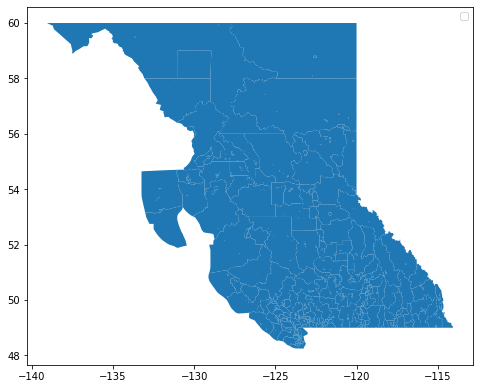

In [71]:
fig,ax=plt.subplots(figsize=(8,8))
BC_Sub_Div.plot(ax=ax)
ax.legend()

BC_Sub_Div.crs

## Re-project the Data

No handles with labels found to put in legend.


<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

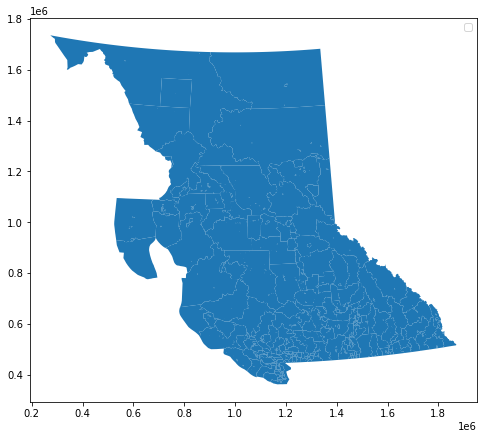

In [72]:
BC_Sub_Div_Albers = BC_Sub_Div.to_crs('EPSG:3005')

fig,ax=plt.subplots(figsize=(8,8))
BC_Sub_Div_Albers.plot(ax=ax)
ax.legend()

BC_Sub_Div_Albers.crs

## Inspect the Geometry

In [76]:
BC_Sub_Div_Albers.area

0      1.102267e+08
1      1.938143e+08
2      1.427249e+07
3      4.629576e+09
4      2.857648e+09
           ...     
732    8.630355e+10
733    1.168956e+05
734    9.570580e+07
735    2.217388e+05
736    5.569671e+06
Length: 737, dtype: float64

## Calculate a Field

In [109]:
BC_Sub_Div_Albers['Pop_Density'] = BC_Sub_Div_Albers['Population']/BC_Sub_Div_Albers.area*1e6


## Map by a Column

<AxesSubplot:>

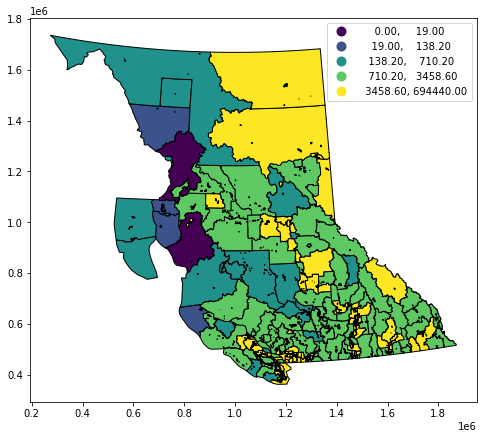

In [136]:
fig,ax=plt.subplots(figsize=(8,8))
BC_Sub_Div_Albers.plot(column='Population',ax=ax,legend=True,scheme="quantiles",edgecolor='k')
# ax.legend()



## Clipping Data

Text(0.5, 1.0, 'Final Result')

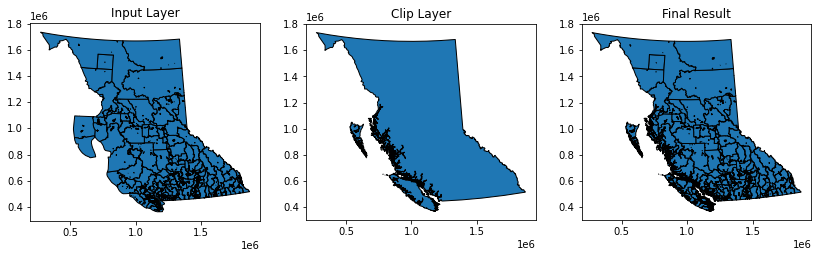

In [98]:
BC_Boundary = gpd.read_file('Data/Census/BC_Boudary_File.shp')
BC_Sub_Div_Clip = gpd.clip(BC_Sub_Div_Albers,BC_Boundary)

fig,ax = plt.subplots(1,3,figsize=(14,5))

BC_Sub_Div_Albers.plot(edgecolor='k',ax=ax[0])
BC_Boundary.plot(edgecolor='k',ax=ax[1])
BC_Sub_Div_Clip.plot(edgecolor='k',ax=ax[2])

ax[0].set_title('Input Layer')
ax[1].set_title('Clip Layer')
ax[2].set_title('Final Result')



## Calculate Population Density

(400000.0, 600000.0)

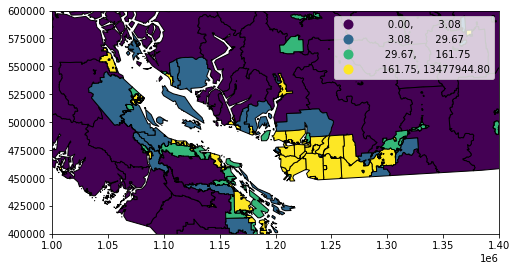

In [133]:
BC_Sub_Div_Clip['Pop_Density'] = BC_Sub_Div_Clip['Population']/BC_Sub_Div_Clip.area*1e6
BC_Sub_Div_Clip['Pop_Density']=BC_Sub_Div_Clip['Pop_Density'].fillna(0)

fig,ax=plt.subplots(figsize=(8,8))
BC_Sub_Div_Clip.plot(column='Pop_Density',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[
             BC_Sub_Div_Clip['Pop_Density'].quantile(.25),
             BC_Sub_Div_Clip['Pop_Density'].quantile(.5),
             BC_Sub_Div_Clip['Pop_Density'].quantile(.75),
             BC_Sub_Div_Clip['Pop_Density'].max()]),
                    edgecolor='k')

ax.set_xlim(1e6,1.4e6)
ax.set_ylim(4e5,6e5)

# Vector Overlay


Lets import a points layer for some locations in BC and walk through a handful of vector overlay methods.

<IPython.core.display.Javascript object>


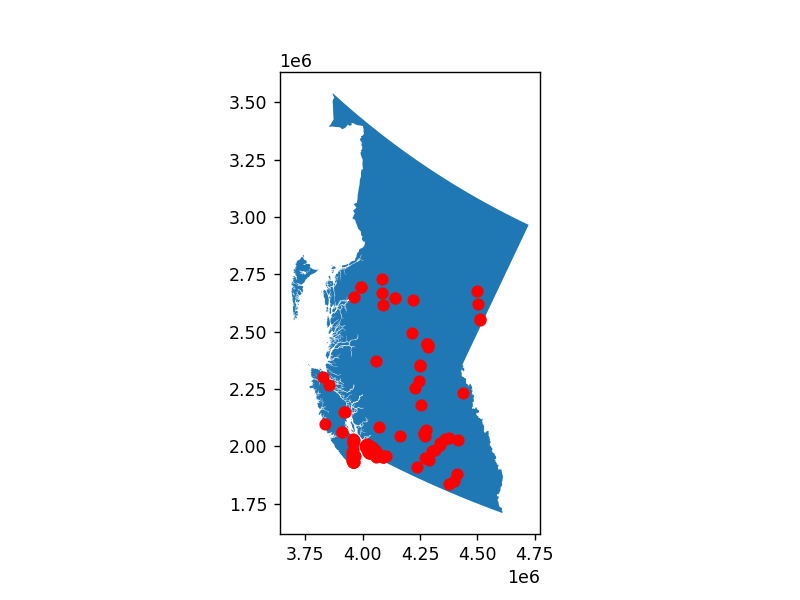

<AxesSubplot:>

In [20]:
Test_Points = gpd.read_file('data/Test_Points.shp')
fig,ax = plt.subplots()
BC = Provincial_Boundaries.loc[Provincial_Boundaries['PRNAME']=='British Columbia']
BC.plot(ax=ax)
Test_Points.plot(ax=ax,color='r')


## Spatial Joins

We can use a [spatial join](https://geopandas.org/gallery/spatial_joins.html) to merge attributes between two layers based on location

In [21]:
# Changin how to "right" will significantly increase the runtime
# and duplicate each province multiple times (once for each incident within it)
Test_Join = gpd.sjoin(Test_Points, BC, how="left") 

Test_Join

,prov_left,city_town,address_in,geometry,index_right,PRNAME,prov_right,Total Pop
0,British Columbia,Enderby,None,POINT (4336484.006 2006697.607),59.0,British Columbia,BC,4648055.0
1,British Columbia,Coquitlam,1100 Heffley Crescent,POINT (4039867.017 1995770.532),59.0,British Columbia,BC,4648055.0
2,British Columbia,Campbell River,2072 S Island Hwy,POINT (3923846.457 2147697.972),59.0,British Columbia,BC,4648055.0
3,British Columbia,Surrey,72 Avenue and 132 Street,POINT (4039411.063 1977638.624),59.0,British Columbia,BC,4648055.0
4,British Columbia,Surrey,6000 block of 134A Street,POINT (4029166.919 1984824.180),59.0,British Columbia,BC,4648055.0
...,...,...,...,...,...,...,...,...
149,British Columbia,Vancouver,900 block of Jervis St.,POINT (4019858.051 2005651.801),59.0,British Columbia,BC,4648055.0
150,British Columbia,Vancouver,600 block of Davie St.,POINT (4018041.610 2007454.076),59.0,British Columbia,BC,4648055.0
151,British Columbia,Vancouver,4800 block of Slocan St.,POINT (4020746.793 2005873.465),59.0,British Columbia,BC,4648055.0
152,British Columbia,Langford (Western Communities),Trans Canada Hwy,POINT (3951549.311 1939531.103),59.0,British Columbia,BC,4648055.0


<IPython.core.display.Javascript object>


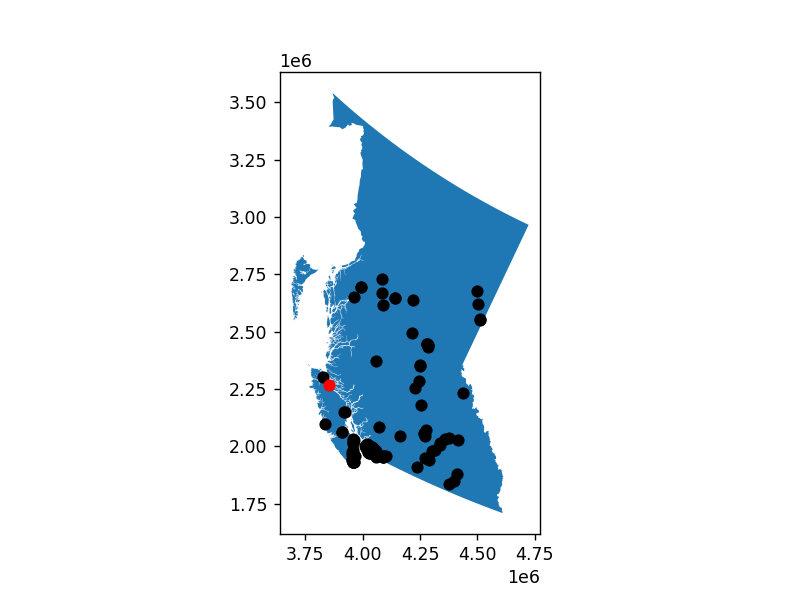

<AxesSubplot:>

In [22]:
fig,ax=plt.subplots()
BC.plot(ax=ax)
## See if there are any locations "outside" the provincial boundaries
Test_Join.loc[Test_Join['PRNAME'].isnull()==False].plot(ax=ax,color='k')
Test_Join.loc[Test_Join['PRNAME'].isnull()].plot(ax=ax,color='r')

## Join the Census Divisions Instead

The census division boundaries don't follow the coastline, so they can include the points that are slightly outside the provincial boundaries.

In [23]:
Test_Join = gpd.sjoin(Test_Points, Census_Divisions, how="left")

print('Not Joined: ',Test_Join.loc[Test_Join['spatial_id'].isnull()].count()['spatial_id'])

Not Joined:  0


## Point In Polygon Analysis

The spatial join method is useful in some cases, but for others, it produces a lot of redundancy.  If your goal is to calculate the number of points per polygon, we can do a point in polygon analysis using the [.within()](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.within.html#geopandas.GeoSeries.within) method. 

In [24]:
Census_Divisions['Count'] = 0.0
for i,row in Census_Divisions.iterrows():
    pip = Test_Points.within(row['geometry'])
    if pip.sum()>0:
#         print(pip.sum())
        Census_Divisions.loc[Census_Divisions.index==i,'Count']+=pip.sum()
print(Census_Divisions['Count'].describe())

count    293.000000
mean       0.525597
std        4.427907
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       73.000000
Name: Count, dtype: float64


<IPython.core.display.Javascript object>


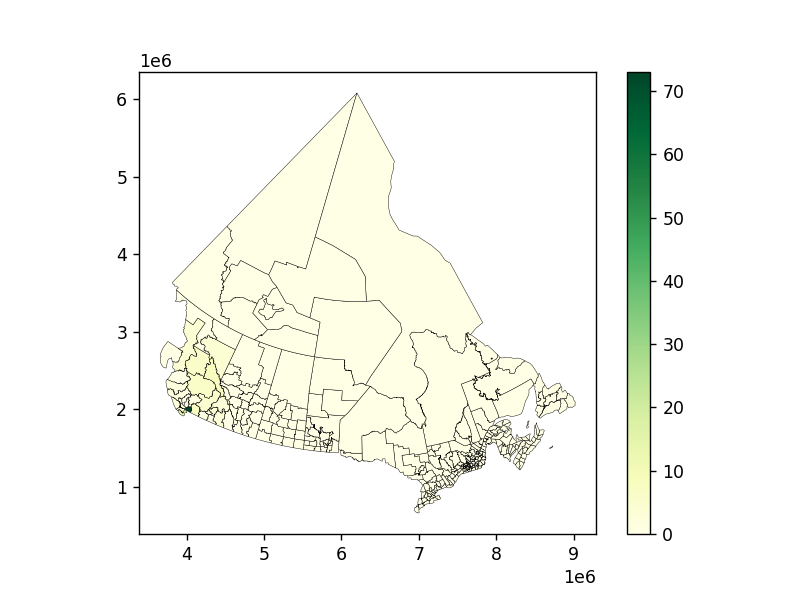

<AxesSubplot:>

In [25]:
Census_Divisions.plot(column='Count',cmap = 'YlGn',legend=True,edgecolor='k',linewidth=.25)

## Clipping a Layer

We can clip the Census Divisions to the the Provincial Boundary Layer so things "look" better.  We can do this with the [.clip()](https://geopandas.org/docs/reference/api/geopandas.clip.html) command.  This command just takes the layer you want to clip as the first input and the layer you want it clipped to as the second input.  Clipping large files takes a bit of time, we can import the [time](https://docs.python.org/3/library/time.html) module to calculate exactly how long this process takes us.

In [ ]:
import time
T1 = time.time()
Census_Divisions_clip = gpd.clip(Census_Divisions,Provincial_Boundaries)
T2 = time.time()
print('Total Runtime: ',T2-T1)
Census_Divisions_clip.plot(edgecolor='black')

## Save the Data

We're going to save the re-projected Census Division Layer with the updated column names and new variables.  We'll save the non-clipped (You will explain why later).

In [ ]:
# Provincial_Boundaries.to_file('Data/CensusData/Provincial_Boundaries_Joined.shp')
Census_Divisions=Census_Divisions.drop('Count',axis=1)
Census_Divisions.to_file('Data/CensusData/Census_Divisons.shp')

In [ ]:

from sklearn.neighbors import KernelDensity

In [35]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

<IPython.core.display.Javascript object>


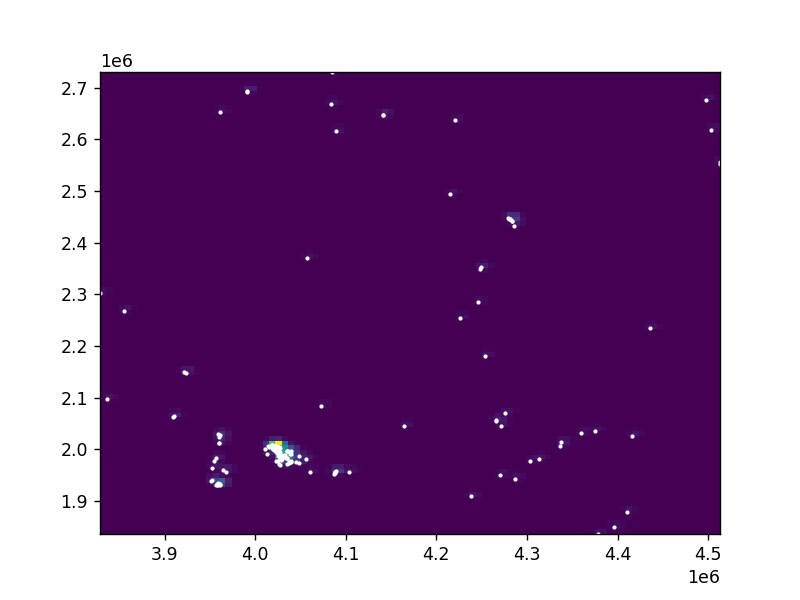

0.0008639570921974116
(100, 100)


C:\Users\User\AppData\Local\Temp/ipykernel_13704/363274592.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, zz)


In [40]:
# import numpy as np
# import matplotlib.pyplot as plt

# m1 = np.random.normal(size=1000)
# m2 = np.random.normal(scale=0.5, size=1000)


x, y =Test_Join.geometry.x.values,Test_Join.geometry.y.values




xx, yy, zz = kde2D(x, y,5e3)
fig,ax=plt.subplots()
ax.pcolormesh(xx, yy, zz)
ax.scatter(x, y, s=2, facecolor='white')

print(zz.max()*1e6)

print(zz.shape)